In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px
import nbformat
import random
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
df = pd.read_excel("./data/Pittsburgh_AMS_Mobile_2016_2017.xlsx")

In [5]:
df_NO2 = df.dropna(subset=['NO2'])

In [6]:
# 13K
df_NO2.shape

(13377, 47)

In [27]:
df_NO2["date"] = df_NO2["datetime"].dt.date
df_NO2["time"] = df_NO2["datetime"].dt.time
df_NO2["year"] = df_NO2["datetime"].dt.year
df_NO2["day"] = df_NO2["datetime"].dt.day

/var/folders/tp/k1f107px41d6gt437332cg440000gn/T/ipykernel_46566/4185981233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["date"] = df_NO2["datetime"].dt.date
/var/folders/tp/k1f107px41d6gt437332cg440000gn/T/ipykernel_46566/4185981233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NO2["time"] = df_NO2["datetime"].dt.time
/var/folders/tp/k1f107px41d6gt437332cg440000gn/T/ipykernel_46566/4185981233.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [40]:
df_NO2["time"].sort_values(ascending=False)

15413    23:21:43
15412    23:21:22
15411    23:21:01
15410    23:20:40
15409    23:20:19
           ...   
470      03:11:00
469      03:10:01
63       03:10:00
62       03:09:01
61       03:07:59
Name: time, Length: 13377, dtype: object

## Exclude held out
held out is the last three days of 2017 Feb

In [8]:
df_testtrain = df_NO2[(df_NO2["day"] <= 14) | (df_NO2["month"] != 2)]

32 different days span from summer, fall, winter; all on week-day

In [10]:
df_testtrain.groupby(["year", "month", "day"]).size()

year  month  day
2016  8      8        61
             9       111
             11      287
             12      286
             15      313
             17       86
      9      13      147
             15      298
             20      303
             22      133
             23       85
             26      288
      11     16      615
             18      740
             21      687
             22      682
2017  1      25     1070
             26      320
             27      324
             30      119
             31      831
      2      1       414
             2       897
             3       488
             6       270
             7       631
             8       171
             13      526
             14      662
dtype: int64

# Train Validation split - 2017-02-03

 split the data into training and validation sets with a simple time-based split:

In [442]:
len(df_testtrain[df_testtrain['NO2']<=0])/len(df_testtrain)

0.13035035880118193

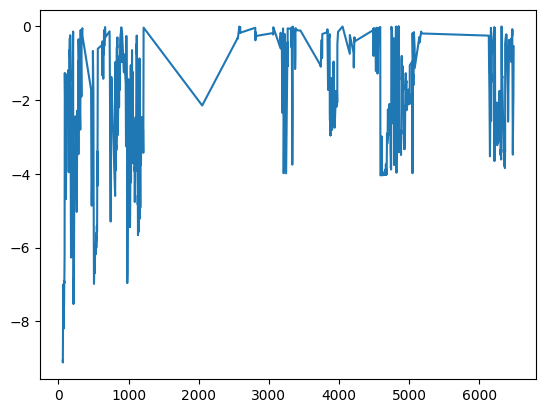

In [441]:
plt.plot(df_testtrain[df_testtrain['NO2']<0]['NO2'])

In [444]:
df_testtrain = df_testtrain[df_testtrain['NO2']>0]

In [487]:
train = df_testtrain.loc[df_testtrain['date'] < pd.to_datetime('2017-02-03').date()]
valid = df_testtrain.loc[df_testtrain['date'] >= pd.to_datetime('2017-02-03').date()]

In [488]:
h = valid['date'].nunique()
h

6

In [489]:
train['time'].dtype

dtype('O')

In [490]:
train['24time'] = train['datetime'].dt.hour + (train['datetime'].dt.minute / 60)
valid['24time'] = valid['datetime'].dt.hour + (valid['datetime'].dt.minute / 60)

/var/folders/tp/k1f107px41d6gt437332cg440000gn/T/ipykernel_46566/4180650789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['24time'] = train['datetime'].dt.hour + (train['datetime'].dt.minute / 60)
/var/folders/tp/k1f107px41d6gt437332cg440000gn/T/ipykernel_46566/4180650789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['24time'] = valid['datetime'].dt.hour + (valid['datetime'].dt.minute / 60)


In [491]:
train_df = train[['24time','NO2']]
valid_df = valid[['24time','NO2']]

In [492]:
train_df

,24time,NO2
0,9.916667,16.362715
1,9.933333,13.752167
2,9.933333,14.866519
3,9.966667,9.649175
4,9.983333,11.266365
...,...,...
10810,10.883333,3.939573
10811,10.883333,7.766743
10812,10.900000,6.843977
10813,10.900000,7.026743


In [493]:
valid_df

,24time,NO2
10815,7.816667,11.171450
10816,7.816667,11.824268
10817,7.816667,12.461205
10818,7.833333,13.141282
10819,7.833333,13.596309
...,...,...
14475,20.866667,13.970605
14476,20.883333,13.750552
14477,20.883333,13.450027
14478,20.883333,13.139177


## aggregate the measurement by each timesep

In [494]:
agg_train = train_df.groupby('24time').mean().reset_index()
agg_valid = valid_df.groupby('24time').mean().reset_index()

In [495]:
len(agg_train)

1100

In [496]:
len(agg_valid)

621

## Remove outlier in training data and validation data

In [522]:
mean = agg_train['NO2'].mean()
std_dev = agg_train['NO2'].std()

In [553]:
print('l:', mean-3 * std_dev ,'h',mean+ 3 * std_dev)

l: -8.674730795220174 h 28.81288519867098


In [523]:
filtered_df = agg_train[(agg_train['NO2'] >= mean - 3 * std_dev) & (agg_train['NO2'] <= mean + 3 * std_dev)]

In [524]:
# remove 10 records
len(agg_train)- len(filtered_df)

10

also apply the outlier removal to validation data

In [549]:
filtered_df2 = agg_valid[(agg_valid['NO2'] >= mean - 3 * std_dev) & (agg_valid['NO2'] <= mean + 3 * std_dev)]

In [554]:
agg_valid[(agg_valid['NO2'] < mean - 3 * std_dev) | (agg_valid['NO2'] > mean + 3 * std_dev)]

,24time,NO2
18,8.116667,41.851121
19,8.133333,51.687398
43,8.533333,47.157810
57,9.166667,32.413762
58,9.183333,29.931720
68,9.350000,35.389746
128,11.183333,32.996518
165,11.983333,38.221166
213,13.000000,35.650730
223,13.166667,29.706145


In [555]:
len(agg_valid)- len(filtered_df2)

18

In [557]:
agg_valid = filtered_df2

## Sample size

In [592]:
print(f"Training sample size: {len(agg_train)}")

Training sample size: 1090


In [594]:
print(f"Validation sample size: {len(agg_valid)}")

Validation sample size: 603


In [558]:
agg_train = filtered_df

## ? Time-of-day trend is different

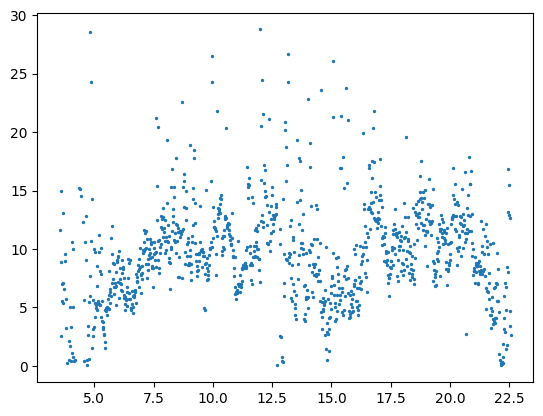

In [559]:
plt.scatter(agg_train['24time'], agg_train['NO2'],s=2)

(0.0, 30.0)

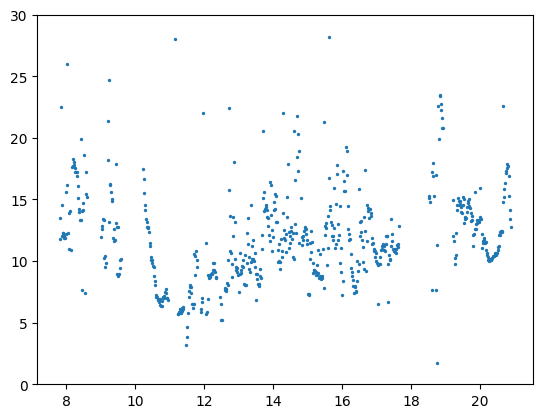

In [560]:
plt.scatter(agg_valid['24time'], agg_valid['NO2'],s=2)
plt.ylim(0,30)

## Model Fitting

In [561]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ExpSineSquared

In [562]:
#kernel = 1.0 * RBF(1.0)+ WhiteKernel(noise_level=0.1)

In [563]:
#kernel = DotProduct() + WhiteKernel()

In [564]:
#kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)

In [721]:
#kernel = ExpSineSquared(length_scale_bounds=[1,1e5], periodicity=1)

In [971]:
kernel = ExpSineSquared(length_scale=1e-5,periodicity=0.28,periodicity_bounds="fixed", length_scale_bounds= "fixed")

In [972]:
#kernel = 59.3**2* RBF(length_scale_bounds=[1,1e5])+ WhiteKernel(noise_level=0.1)

In [973]:
noise = 0.2

In [974]:
clf = GaussianProcessRegressor(kernel=kernel, alpha=noise**2,random_state=42)

In [975]:
clf.fit(agg_train['24time'].values.reshape(-1,1), agg_train['NO2'])

GaussianProcessRegressor(alpha=0.04000000000000001,
                         kernel=ExpSineSquared(length_scale=1e-05, periodicity=0.28),
                         random_state=42)

In [976]:
y_pred = clf.predict(agg_train['24time'].values.reshape(-1,1),return_std=True)

In [977]:
y_pred_valid = clf.predict(agg_valid['24time'].values.reshape(-1,1),return_std=True)

In [978]:
y_pred_valid

(array([ 9.68576568,  9.47021122,  9.44390645,  9.62156428,  9.07947126,
         9.88161569,  9.10276756,  9.97673797, 10.12745982,  9.94377499,
        10.10301949,  8.98582972, 10.06653736,  9.77812824, 10.60035635,
        12.45508511,  8.23804093,  9.881653  ,  7.56050337,  8.69695228,
         7.95337643,  7.27283571,  8.45956244,  7.62993881,  8.90351411,
         8.35367425,  9.10653161,  9.35760791,  9.55666948,  9.89228087,
         8.81188102,  8.34344097,  9.67873975, 11.58092211,  9.60819776,
         9.51237013, 10.259057  , 10.32790572, 10.03113118, 10.63659424,
        10.27093806, 10.41848289, 10.63978705,  8.92084376,  9.59008215,
        10.0527608 , 11.82771758, 10.72422541,  8.98152383,  8.25188915,
        10.31603129,  8.04093053,  7.60788071,  9.40680362,  9.75364698,
         9.68576568,  9.47021122,  9.44390645,  9.62156428,  9.07947126,
         9.88161569,  9.10276756,  9.97673797,  9.94377499, 10.10301949,
         8.98582972, 10.06653736,  9.77812824, 10.6

In [979]:
y_pred_valid[0]-2*y_pred_valid[1]

array([ 9.57901357,  9.36345912,  9.33715435,  9.51481217,  8.97271916,
        9.77486359,  8.99601545,  9.86596821, 10.01669006,  9.83702289,
        9.99224974,  8.87907762,  9.95978526,  9.67137613, 10.48507826,
       12.33980703,  8.12727118,  9.76637492,  7.44973362,  8.59020018,
        7.84662433,  7.16206596,  8.35281033,  7.51916905,  8.796762  ,
        8.24692215,  8.9997795 ,  9.25085581,  9.44991738,  9.78552877,
        8.70111126,  8.23668886,  9.56796999, 11.47015236,  9.49742801,
        9.40160038, 10.14828724, 10.21713596,  9.92036142, 10.52582449,
       10.15565998, 10.3032048 , 10.52901729,  8.8004579 ,  9.47480407,
        9.94199104, 11.71694783, 10.61345565,  8.87075407,  8.13661106,
       10.20526153,  7.93016077,  7.49711095,  9.30005151,  9.64689488,
        9.57901357,  9.36345912,  9.33715435,  9.51481217,  8.97271916,
        9.77486359,  8.99601545,  9.86596821,  9.83702289,  9.99224974,
        8.87907762,  9.95978526,  9.67137613, 10.48507826, 12.33

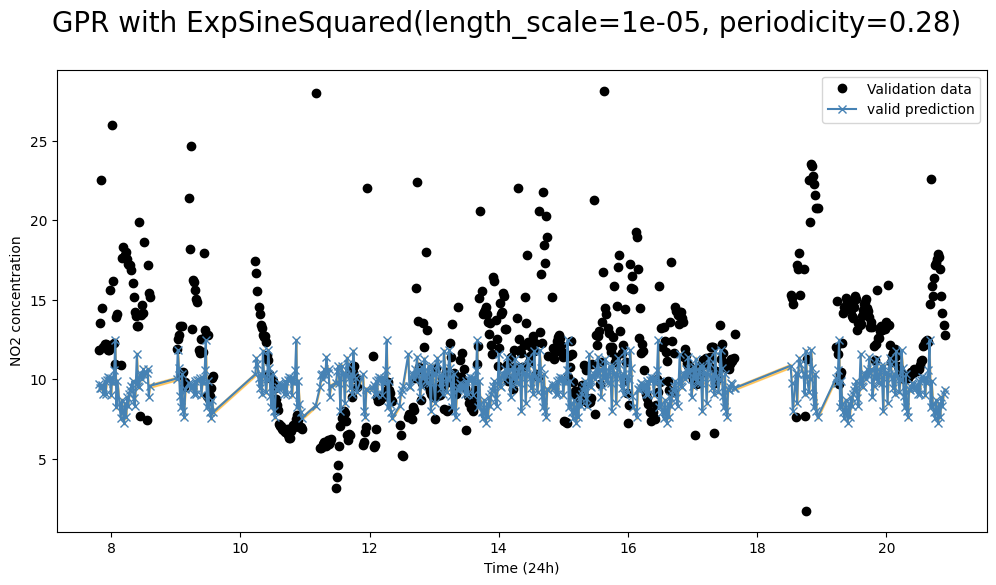

In [980]:
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.plot(agg_valid['24time'], agg_valid['NO2'], color='black', marker='o',label="Validation data",linewidth=0) # 
# plt.scatter(agg_train['24time'], agg_train['NO2'], color="red", label="Training data")
plt.plot(agg_valid['24time'], y_pred_valid[0], marker='x', color='steelblue',label="valid prediction")
plt.fill_between(agg_valid['24time'], y_pred_valid[0] - 2 * y_pred_valid[1], y_pred_valid[0] + 2 * y_pred_valid[1],color='orange', alpha=0.5)
plt.xlabel("Time (24h)")
plt.ylabel("NO2 concentration") # Set y-axis label
plt.suptitle(f"GPR with {clf.kernel_}", fontsize=20)
plt.legend() 

In [981]:
print(clf.kernel_.get_params()) 

{'length_scale': 1e-05, 'periodicity': 0.28, 'length_scale_bounds': 'fixed', 'periodicity_bounds': 'fixed'}


In [982]:
print(clf.kernel_) 

ExpSineSquared(length_scale=1e-05, periodicity=0.28)


In [983]:
clf.score(agg_valid['24time'].values.reshape(-1,1), agg_valid['NO2'])

-0.49297864890138055

## A negative R² score indicates that the model is a poor fit for the data. 

## Try MSE

In [984]:
# check the training data
from sklearn.metrics import mean_squared_error, r2_score

In [985]:
train_mse  = mean_squared_error(y_pred[0], agg_train['NO2'])
train_r2 = r2_score(agg_train['NO2'], y_pred[0])

In [986]:
print(f"Training MSE: {train_mse:.3f}") # Print MSE
print(f"Training R^2: {train_r2:.3f}") # Print R^2

Training MSE: 16.401
Training R^2: 0.063


In [987]:
clf.log_marginal_likelihood()

-226943.23619543266

In [988]:
mse  = mean_squared_error(y_pred_valid[0], agg_valid['NO2'])
r2 = r2_score(agg_valid['NO2'], y_pred_valid[0])

In [989]:
print(f"Validation MSE: {mse:.3f}") # Print MSE
print(f"Validation R^2: {r2:.3f}") # Print R^2

Validation MSE: 21.057
Validation R^2: -0.493


# Tune Period

/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as sho

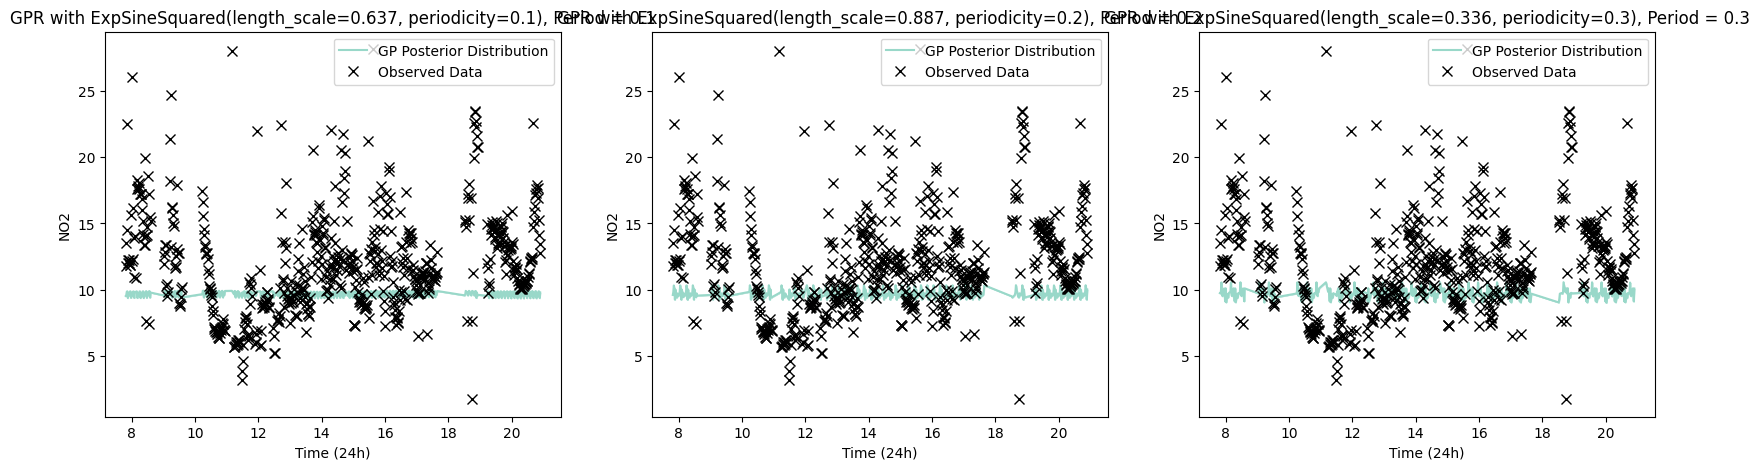

In [1000]:
# We will compare the quality of different period choices.
periods = np.linspace(0.1,0.3,100)
log_likelihoods = np.zeros(periods.shape)

# Let's start by plotting few length scales.
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

for i, period in enumerate([0.1, 0.2, 0.3]):
    # TODO: Use the looped period parameter to initialize the kernel function.
    amplitude_cosine = 2.0
    length_scale = 0.2
    amplitude_se = 2.0
    kernel_function = ExpSineSquared(length_scale=1,periodicity = period, periodicity_bounds='fixed')
    gp = GaussianProcessRegressor(kernel=kernel_function)
    gp.fit(agg_train['24time'].values.reshape(-1,1), agg_train['NO2'])
    y_pred_mean, y_pred_cov = gp.predict(agg_valid['24time'].values.reshape(-1,1),return_cov= True)
    y_pred_std = np.sqrt(np.diag(y_pred_cov))
    ax[i].plot(agg_valid['24time'], y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
    ax[i].plot(agg_valid['24time'], agg_valid['NO2'], 'x', color = 'k', label = 'Observed Data', markersize=7)
    #ax[i].plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
    ax[i].fill_between(agg_valid['24time'], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std, 
                       color = '#99d8c9', alpha=0.5)
    ax[i].legend()
    ax[i].set_xlabel('Time (24h)')
    ax[i].set_ylabel('NO2')
    #ax[i].set_ylim([-10,10])
    ax[i].set_title(f'GPR with {gp.kernel_}, Period = {period}')

/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/manlizhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings

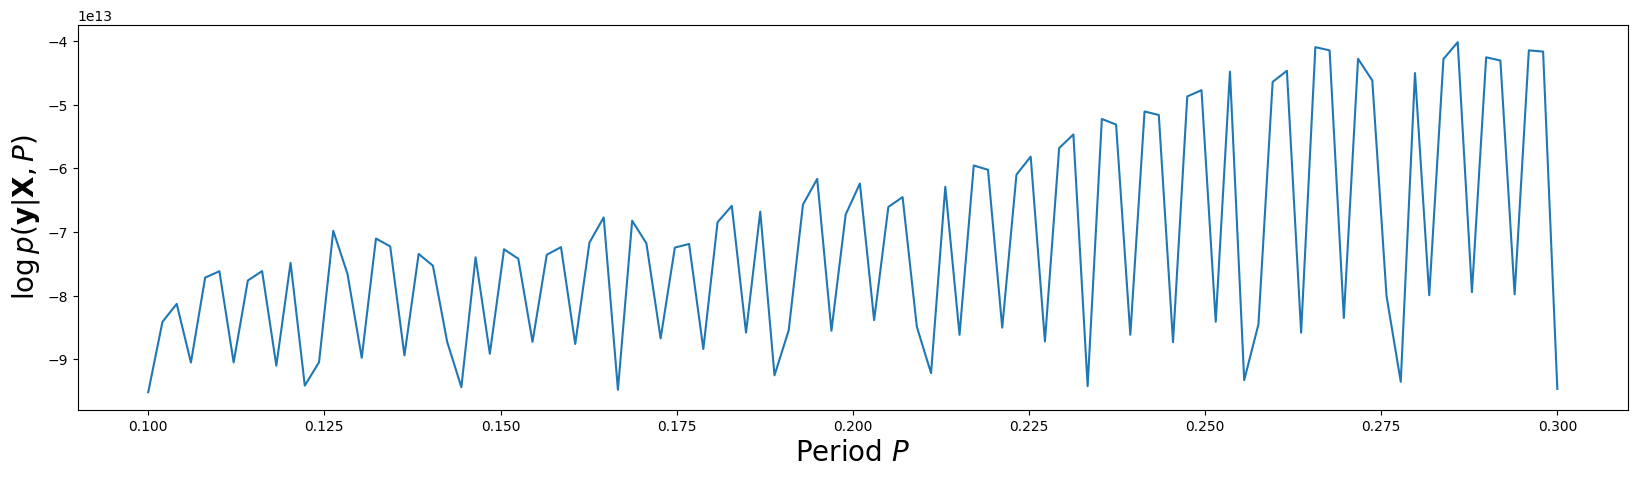

In [1001]:
for i, period in enumerate(periods):
    # TODO: Use the looped period parameter to initialize the kernel function.
    amplitude_cosine = 2.0
    length_scale = 0.2
    amplitude_se = 2.0
    kernel_function = ExpSineSquared(length_scale=1,periodicity = period, periodicity_bounds="fixed")
    gp = GaussianProcessRegressor(kernel=kernel_function)
    gp.fit(agg_train['24time'].values.reshape(-1,1), agg_train['NO2'])
    log_likelihoods[i] = gp.log_marginal_likelihood()

plt.figure(figsize=(20,5))
plt.plot(periods, log_likelihoods)
# plt.axvline(0.2, c='k')
plt.xlabel(r'Period $P$', fontsize=20)
plt.ylabel(r'$\log p(\mathbf{y}|\mathbf{X},P)$', fontsize=20)

plt.show()

In [1002]:
log_likelihoods.max()

-40188054792126.56

In [1003]:
log_likelihoods.min()

-95158310133013.2

In [994]:
# exponential sine square
